# Lyft Driver Lifetime Value

In [269]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

## Evaluation
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, roc_curve, r2_score,ConfusionMatrixDisplay
from keras import metrics

import warnings 
warnings.filterwarnings('ignore')

In [270]:
## Reading data
driver=pd.read_csv('driver_ids.csv')
ride=pd.read_csv('ride_ids.csv')
ride_ts=pd.read_csv('ride_timestamps.csv')

In [271]:
print(driver.shape)
print(ride.shape)
print(ride_ts.shape)

(937, 2)
(193502, 5)
(970405, 3)


In [272]:
print ("Driver details \n")
print(driver.head(3))
print ("\nRide details \n")
print(ride.head(3))
print ("\nRide time details \n")
print(ride_ts.head(3))

Driver details 

                          driver_id  driver_onboard_date
0  002be0ffdc997bd5c50703158b7c2491  2016-03-29 00:00:00
1  007f0389f9c7b03ef97098422f902e62  2016-03-29 00:00:00
2  011e5c5dfc5c2c92501b8b24d47509bc  2016-04-05 00:00:00

Ride details 

                          driver_id                           ride_id  \
0  002be0ffdc997bd5c50703158b7c2491  006d61cf7446e682f7bc50b0f8a5bea5   
1  002be0ffdc997bd5c50703158b7c2491  01b522c5c3a756fbdb12e95e87507eda   
2  002be0ffdc997bd5c50703158b7c2491  029227c4c2971ce69ff2274dc798ef43   

   ride_distance  ride_duration  ride_prime_time  
0           1811            327               50  
1           3362            809                0  
2           3282            572                0  

Ride time details 

                            ride_id         event            timestamp
0  00003037a262d9ee40e61b5c0718f7f0  requested_at  2016-06-13 09:39:19
1  00003037a262d9ee40e61b5c0718f7f0   accepted_at  2016-06-13 09:39:51
2  00003

In [273]:
print ("Driver details \n")
print(driver.dtypes)
print ("\nRide details \n")
print(ride.dtypes)
print ("\nRide time details \n")
print(ride_ts.dtypes)

Driver details 

driver_id              object
driver_onboard_date    object
dtype: object

Ride details 

driver_id          object
ride_id            object
ride_distance       int64
ride_duration       int64
ride_prime_time     int64
dtype: object

Ride time details 

ride_id      object
event        object
timestamp    object
dtype: object


In [274]:
## Correcting datatypes
driver['driver_onboard_date']=pd.to_datetime(driver['driver_onboard_date'])
ride_ts['timestamp']=pd.to_datetime(ride_ts['timestamp'])

In [275]:
print ("Driver details \n")
print(driver.describe(include='all'))
print ("\nRide details \n")
print(ride.describe(include='all'))
print ("\nRide time details \n")
print(ride_ts.describe(include='all'))

Driver details 

                               driver_id  driver_onboard_date
count                                937                  937
unique                               937                   49
top     002be0ffdc997bd5c50703158b7c2491  2016-04-05 00:00:00
freq                                   1                   36
first                                NaN  2016-03-28 00:00:00
last                                 NaN  2016-05-15 00:00:00

Ride details 

                               driver_id                           ride_id  \
count                             193502                            193502   
unique                               937                            193502   
top     5ccc0e6dc9c7475caf785cdce7b8eb7a  006d61cf7446e682f7bc50b0f8a5bea5   
freq                                 919                                 1   
mean                                 NaN                               NaN   
std                                  NaN                         

In [276]:
final=pd.merge(ride,driver,'left',on='driver_id')
#final.describe(include='all')
## 84 drivers don't have onboarding date but have ride details & 7611 rides have the same

#### There are same no of drivers in ride and driver tables. But the driver id's are different. 
#### However, the unique rides are different. Some rides time details have missing driver info. We might drop it.

In [277]:
ride_t=ride_ts.pivot(index='ride_id',values='timestamp',columns='event').reset_index().rename(columns={'event':'index'})
ride_t.columns=['ride_id', 'accepted_at', 'arrived_at', 'dropped_off_at',
       'picked_up_at', 'requested_at']
ride_t.head()

,ride_id,accepted_at,arrived_at,dropped_off_at,picked_up_at,requested_at
0,00003037a262d9ee40e61b5c0718f7f0,2016-06-13 09:39:51,2016-06-13 09:44:31,2016-06-13 10:03:05,2016-06-13 09:44:33,2016-06-13 09:39:19
1,00005eae40882760d675da5effb89ae3,2016-05-14 05:23:25,2016-05-14 05:26:17,2016-05-14 05:34:17,2016-05-14 05:26:18,2016-05-14 05:23:21
2,000061d42cf29f73b591041d9a1b2973,2016-05-16 15:43:14,2016-05-16 15:47:29,2016-05-16 15:54:18,2016-05-16 15:47:32,2016-05-16 15:43:09
3,00006efeb0d5e3ccad7d921ddeee9900,2016-05-11 19:29:43,2016-05-11 19:35:11,2016-05-11 19:40:47,2016-05-11 19:35:15,2016-05-11 19:29:36
4,0000d9b24d8ccdd991b76258e616fa01,2016-04-26 18:12:15,2016-04-26 18:16:52,2016-04-26 18:24:14,2016-04-26 18:16:55,2016-04-26 18:11:38


In [278]:
final=pd.merge(final,ride_t,'left',on='ride_id')
final.describe(include='all')

,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time,driver_onboard_date,accepted_at,arrived_at,dropped_off_at,picked_up_at,requested_at
count,193502,193502,193502.000000,193502.000000,193502.000000,185891,184819,184818,184819,184819,184819
unique,937,193502,NaN,NaN,NaN,49,181510,181599,181573,181586,181521
top,5ccc0e6dc9c7475caf785cdce7b8eb7a,006d61cf7446e682f7bc50b0f8a5bea5,NaN,NaN,NaN,2016-04-05 00:00:00,2016-05-07 20:35:55,2016-05-28 00:40:53,2016-06-03 18:59:26,2016-06-03 21:24:04,2016-05-06 20:39:08
freq,919,1,NaN,NaN,NaN,10696,3,4,4,4,4
first,NaN,NaN,NaN,NaN,NaN,2016-03-28 00:00:00,2016-03-28 05:48:23,2016-03-28 06:02:36,2016-03-28 06:37:51,2016-03-28 06:02:39,2016-03-28 05:48:18
last,NaN,NaN,NaN,NaN,NaN,2016-05-15 00:00:00,2016-06-26 23:57:49,2016-06-27 00:02:03,2016-06-27 00:50:50,2016-06-27 00:02:06,2016-06-26 23:57:45
mean,NaN,NaN,6955.218266,858.966099,17.305893,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,8929.444606,571.375818,30.825800,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,-2.000000,2.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,2459.000000,491.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN


In [279]:
## Check for NULL values
final.isna().sum()

## Handling missing values -  will drop for now
final.dropna(inplace=True)

In [280]:
final['ride_distance']=final['ride_distance']*0.000621371  ## Conveting m to miles
final['ride_duration']=final['ride_duration']/60 ## Converting to mins
final=final[final.ride_distance>0]

In [281]:
print(final.shape)

(184029, 11)


## Features

In [282]:
## Ride Features
final['response_time']=(final['accepted_at']-final['requested_at']).dt.seconds
final['ride_arrival_time']=(final['arrived_at']-final['accepted_at']).dt.seconds
final['wait_time']=(final['picked_up_at']-final['arrived_at']).dt.seconds

## Cost Calculation

## Base Fare $2.00
## Cost per Mile $1.15
## Cost per Minute $0.22
## Service Fee $1.75
## Minimum Fare $5.00
## Maximum Fare $400.00

## Formula: Cost= (Base_Fare + Cost_per_mile * ride_distance + cost_per_minute*ride_duration)*(1+ride_prime_time/100)+service_fee

Cost_per_mile=1.15
Cost_per_minute=0.22
Base_Fare=2.00
service_fee=1.75
min_fare=5.00
max_fare=400.00


final['Ride_Cost']=(Base_Fare + Cost_per_mile * final['ride_distance']+ Cost_per_minute*final['ride_duration'])*(1+(final['ride_prime_time']/100))+service_fee
final['Ride_Cost']=np.where(final.Ride_Cost<min_fare,min_fare,final.Ride_Cost)
final['Ride_Cost']=np.where(final.Ride_Cost>max_fare,max_fare,final.Ride_Cost)


In [283]:
def ride_time(hr):
    #hr=x.dt.hour
    if hr>=6 and hr<15:
        return 'morning ride'
    elif hr>=15 and hr<21:
        return 'evening ride'
    else:
        return 'night ride'
      
final['ride_time']=final.accepted_at.apply(lambda x: ride_time(x.hour))
low=final.ride_distance.quantile(0.33)
high=final.ride_distance.quantile(0.66)
final['ride_length']=final.ride_distance.apply(lambda x: 'short_ride' if x<low else ('long_ride' if x>high else 'med_ride'))


In [284]:
final.head()

,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time,driver_onboard_date,accepted_at,arrived_at,dropped_off_at,picked_up_at,requested_at,response_time,ride_arrival_time,wait_time,Ride_Cost,ride_time,ride_length
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1.125303,5.450000,50,2016-03-29,2016-04-23 02:14:15,2016-04-23 02:16:36,2016-04-23 02:22:07,2016-04-23 02:16:40,2016-04-23 02:13:50,25,141,4,8.489647,night ride,short_ride
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,2.089049,13.483333,0,2016-03-29,2016-03-29 19:00:52,2016-03-29 19:03:57,2016-03-29 19:17:30,2016-03-29 19:04:01,2016-03-29 19:00:49,3,185,4,9.118740,evening ride,med_ride
2,002be0ffdc997bd5c50703158b7c2491,029227c4c2971ce69ff2274dc798ef43,2.039340,9.533333,0,2016-03-29,2016-06-21 11:56:39,2016-06-21 12:01:32,2016-06-21 12:11:07,2016-06-21 12:01:35,2016-06-21 11:56:31,8,293,3,8.192574,morning ride,med_ride
3,002be0ffdc997bd5c50703158b7c2491,034e861343a63ac3c18a9ceb1ce0ac69,40.564963,55.633333,25,2016-03-29,2016-05-19 09:15:33,2016-05-19 09:18:20,2016-05-19 10:13:58,2016-05-19 09:18:20,2016-05-19 09:15:29,4,167,0,77.861301,morning ride,long_ride
4,002be0ffdc997bd5c50703158b7c2491,034f2e614a2f9fc7f1c2f77647d1b981,2.556942,13.716667,100,2016-03-29,2016-04-20 22:05:32,2016-04-20 22:07:03,2016-04-20 22:20:45,2016-04-20 22:07:02,2016-04-20 22:05:30,2,91,86399,17.666299,night ride,med_ride


In [285]:
df=final

## EDA

In [286]:
cat_cols=df.select_dtypes(include=['object']).columns.tolist()
num_cols=df.select_dtypes(exclude=['object','datetime64']).columns.tolist()
time_cols=df.select_dtypes(include='datetime64').columns.tolist()
print ("Categorical Columns: ", cat_cols)
print ("\nNumerical Columns: ", num_cols)
print ("\nDatetime Columns: ", time_cols)

Categorical Columns:  ['driver_id', 'ride_id', 'ride_time', 'ride_length']

Numerical Columns:  ['ride_distance', 'ride_duration', 'ride_prime_time', 'response_time', 'ride_arrival_time', 'wait_time', 'Ride_Cost']

Datetime Columns:  ['driver_onboard_date', 'accepted_at', 'arrived_at', 'dropped_off_at', 'picked_up_at', 'requested_at']


In [287]:
print ("Total Drivers: ",df.driver_id.nunique())
print ("Total Rides: ",df.ride_id.nunique())

Total Drivers:  837
Total Rides:  184029


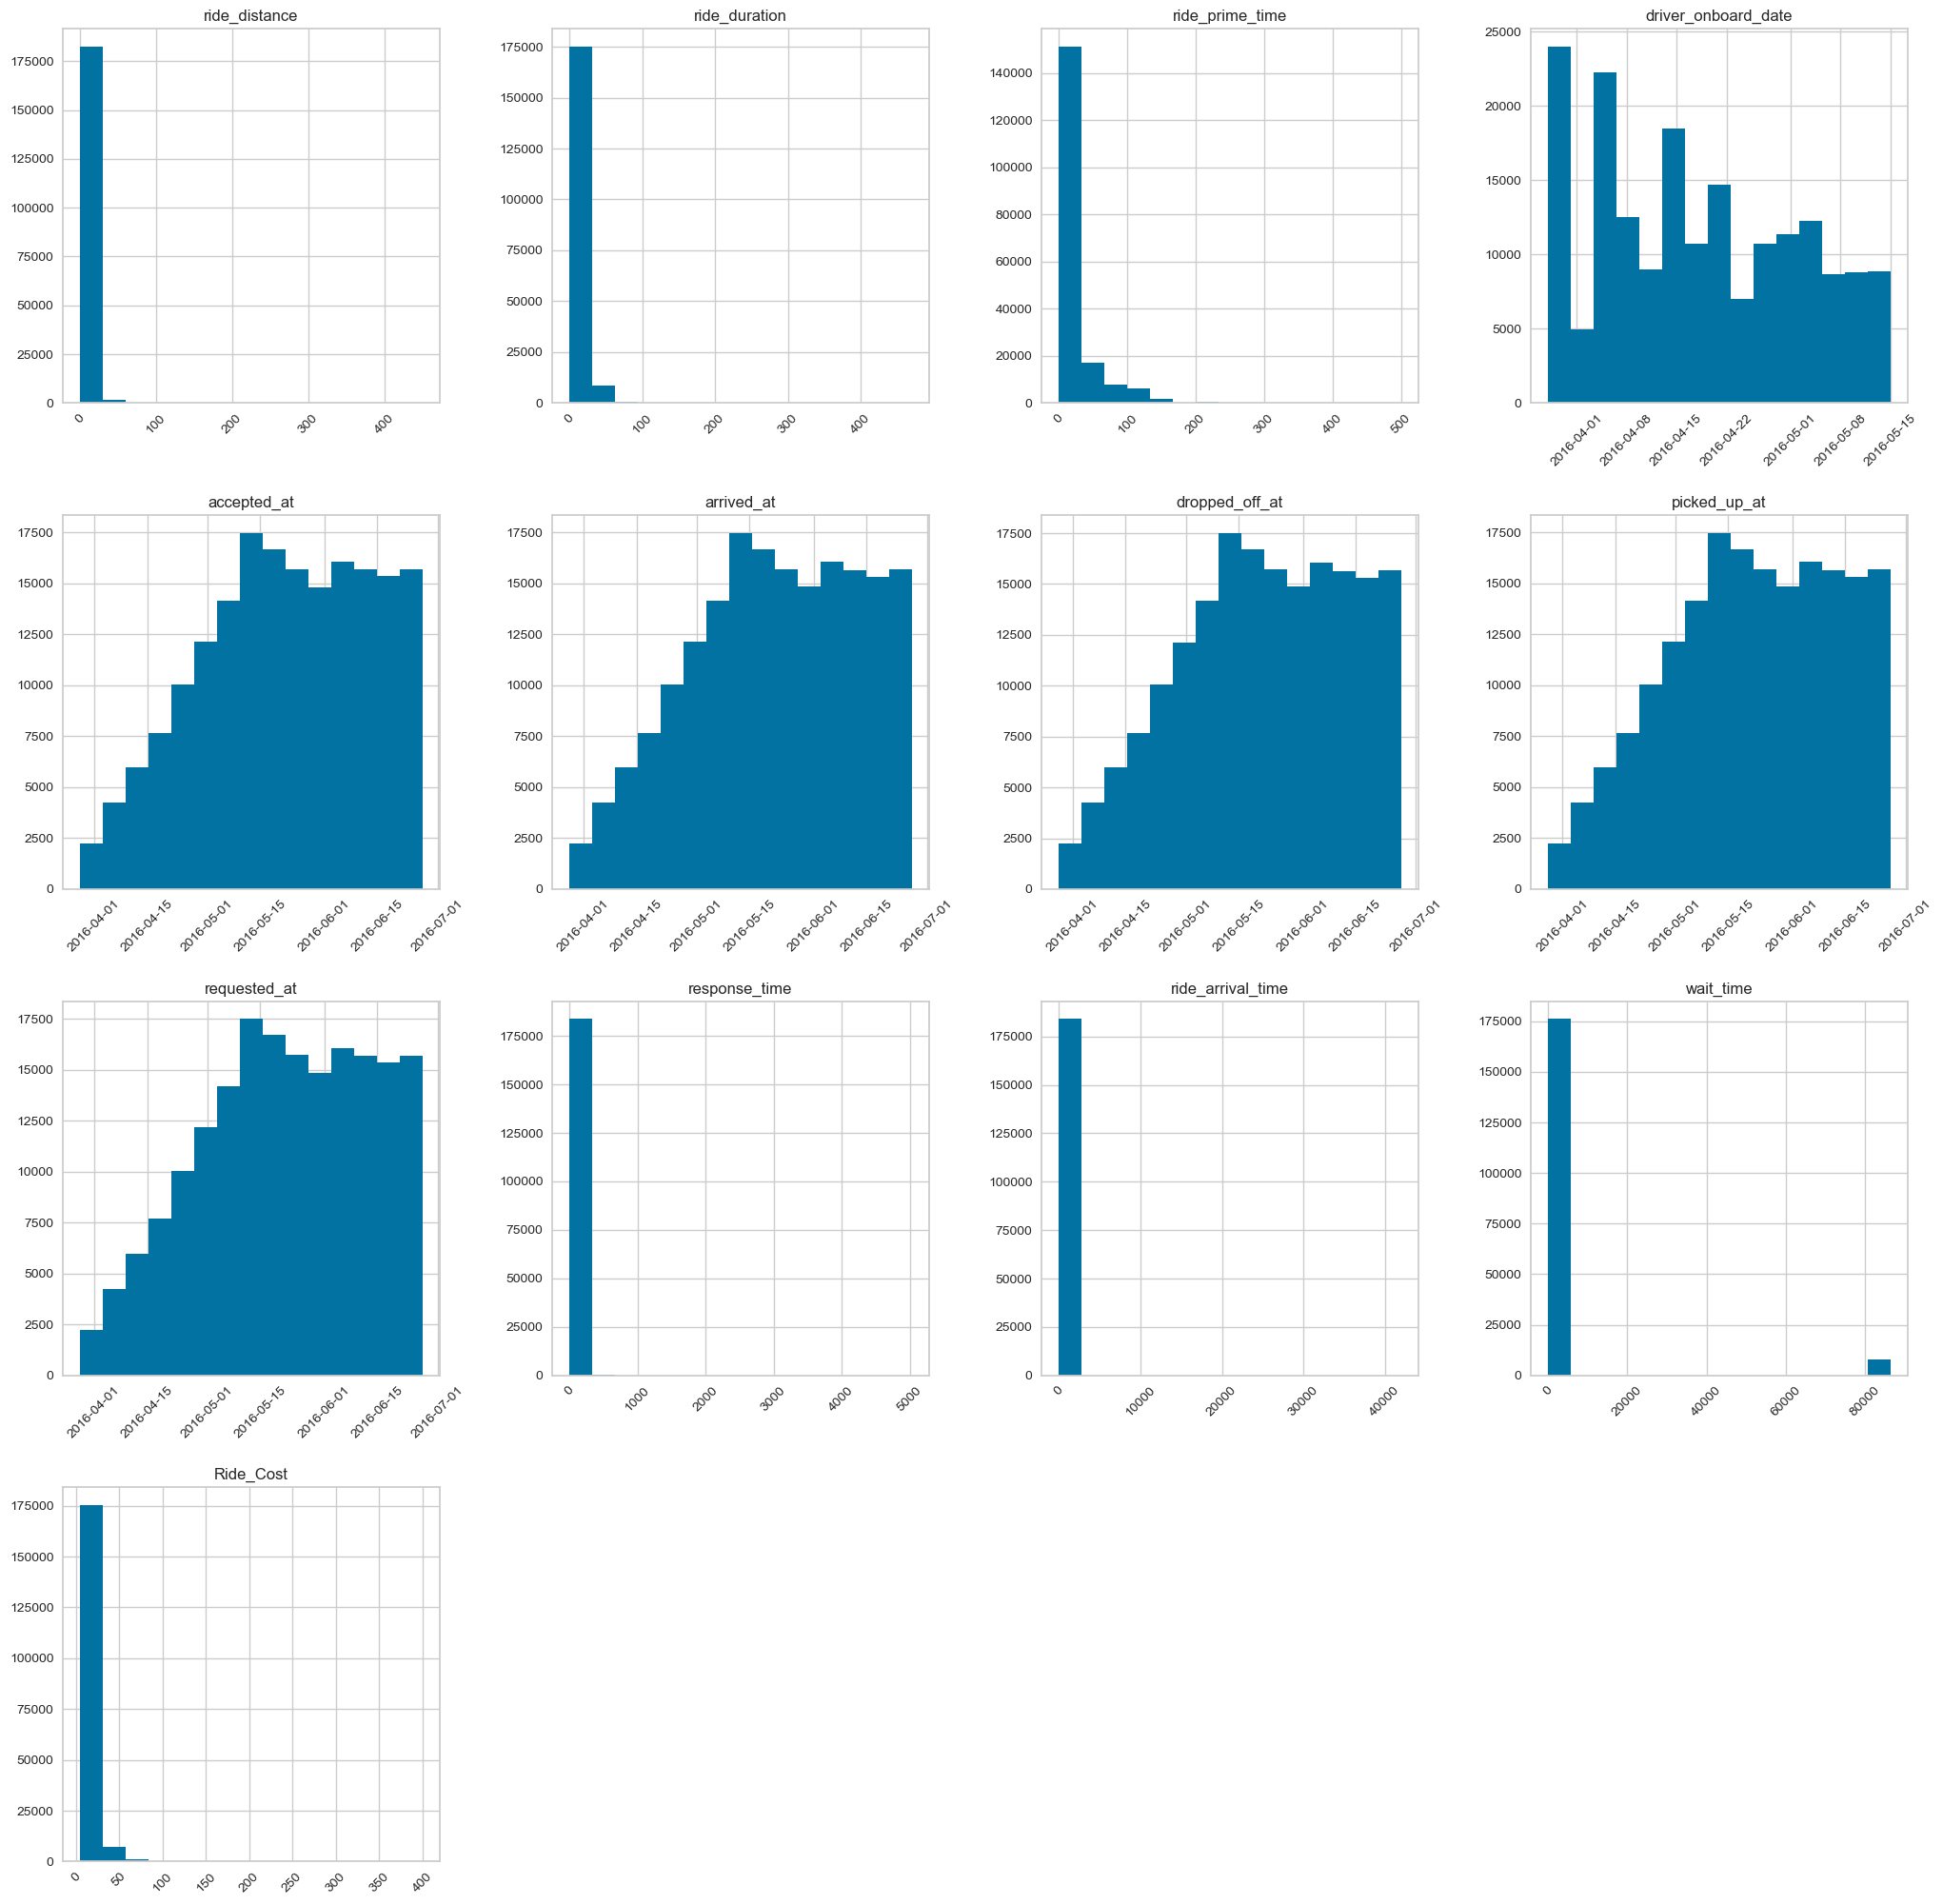

In [288]:
df.hist(figsize=(25,25),bins = 15,xrot=45)
plt.show()

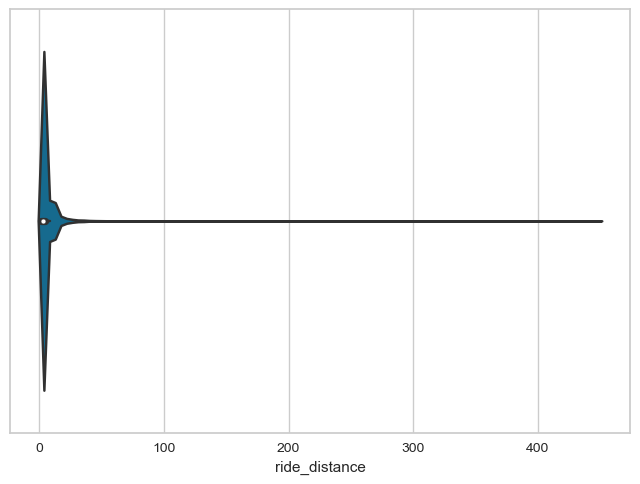

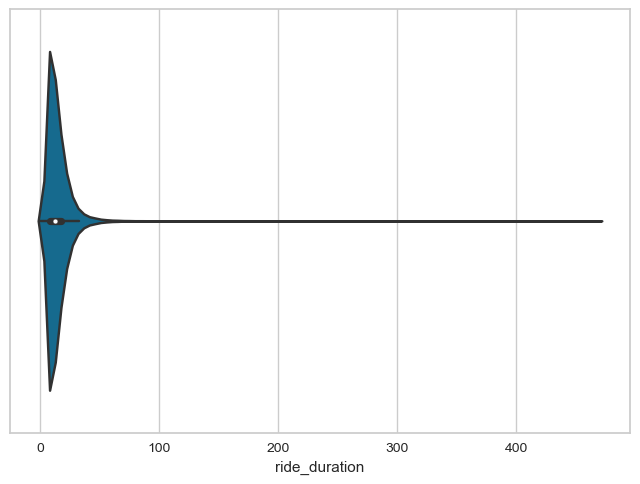

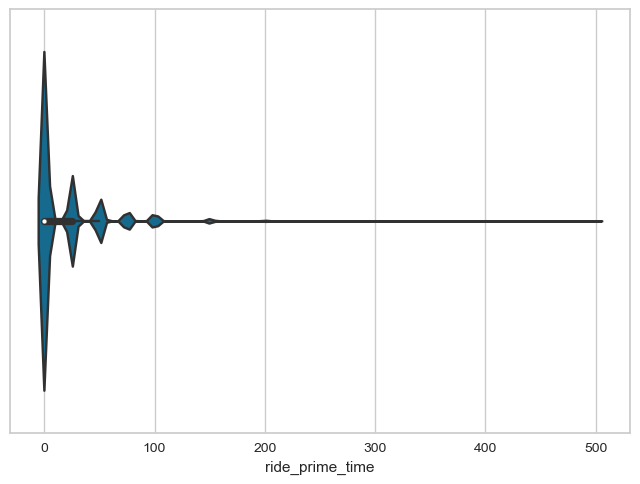

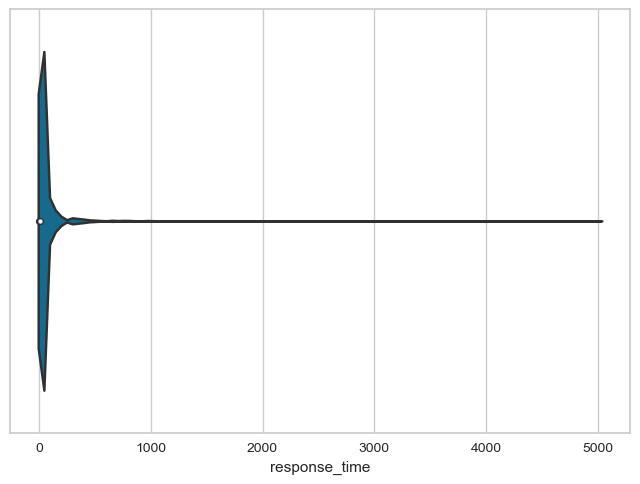

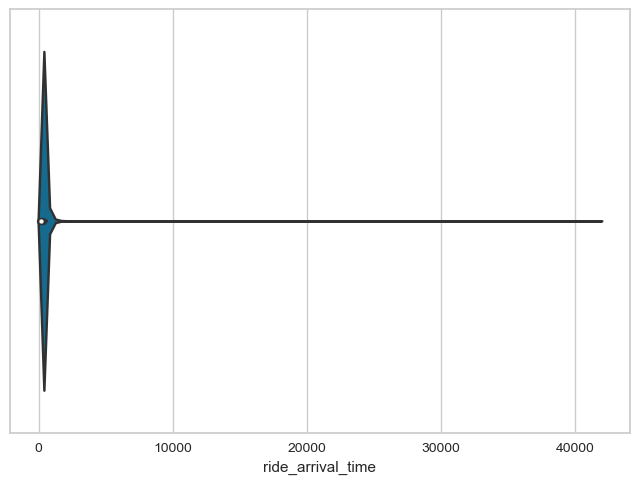

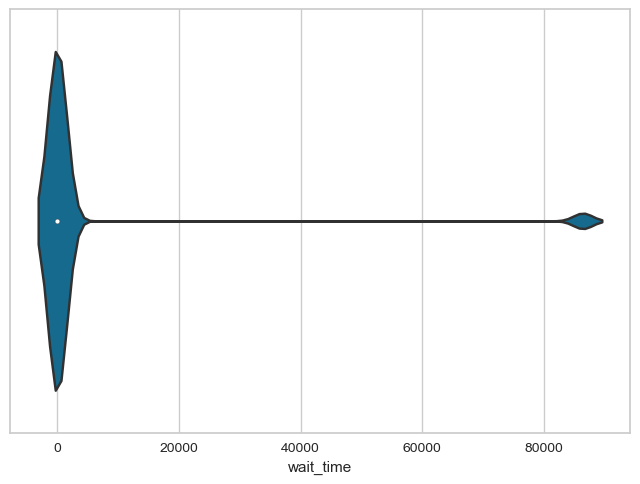

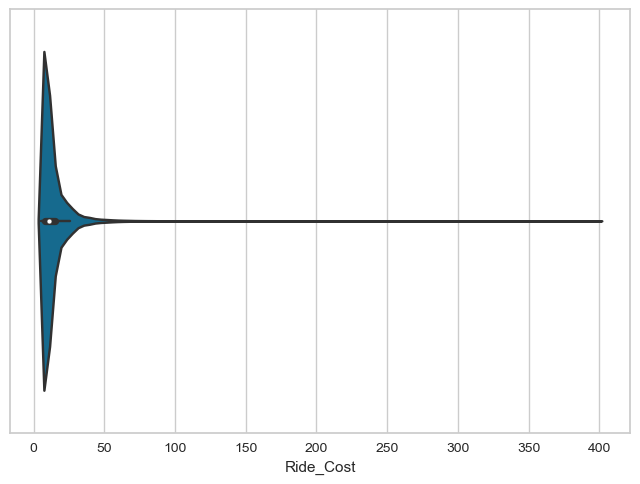

In [289]:
for i in num_cols:
    sns.violinplot(data=df,x=i)
    plt.show()

### Handling Outliers

In [290]:
lower_quantile = 0.01
upper_quantile = 0.99
thresholds = df.quantile([lower_quantile, upper_quantile])
for column in thresholds.columns:
    lower_threshold = thresholds.loc[lower_quantile, column]
    upper_threshold = thresholds.loc[upper_quantile, column]
    df = df[(df[column] >= lower_threshold) & (df[column] <= upper_threshold)]

thresholds

,ride_distance,ride_duration,ride_prime_time,response_time,ride_arrival_time,wait_time,Ride_Cost
0.01,0.446318,2.933333,0.0,1.0,19.0,0.0,5.144751
0.99,27.830561,48.840667,150.0,93.0,915.0,86399.0,53.669783


In [291]:
df.shape

(171461, 17)

In [292]:
# df[thresholds.columns].hist(figsize=(25,25),bins = 15,xrot=45)
# plt.show()

In [293]:
df.pivot_table(index='driver_id',columns='ride_time',aggfunc='size',fill_value=0)

ride_time,evening ride,morning ride,night ride
driver_id,,,
002be0ffdc997bd5c50703158b7c2491,79,85,99
007f0389f9c7b03ef97098422f902e62,18,3,9
011e5c5dfc5c2c92501b8b24d47509bc,21,7,5
0152a2f305e71d26cc964f8d4411add9,16,69,94
01674381af7edd264113d4e6ed55ecda,0,354,0
...,...,...,...
ff419a3476e21e269e340b5f1f05414e,63,143,21
ff714a67ba8c6a108261cd81e3b77f3a,170,276,15
fff482c704d36a1afe8b8978d5486283,2,31,0


### Driver Analysis & Features

In [294]:
driver_df=df
temp=driver_df.groupby('driver_id').agg({'ride_id':['count'],
                                         'Ride_Cost':['sum','mean'],
                                         'ride_distance':['sum','mean'],
                                         'ride_duration':['mean'],
                                         'response_time':['mean'],
                                         'ride_arrival_time':['mean'],
                                         'wait_time':['mean'],
                                         'driver_onboard_date':['min'],
                                         'accepted_at':['min','max']}).reset_index()

temp.columns=['driver_id','total rides','Lifetime value','mean ride cost','Total ride distance','mean ride distance','mean ride duration','mean response time',
             'mean ride_arrival_time','mean_wait_time','driver_onboard_date','first_ride','last_ride']

In [295]:
temp['first_ride_wait_days']=(temp['first_ride']-temp['driver_onboard_date']).dt.days
temp['active_days']=(temp['last_ride']-temp['first_ride']).dt.days
temp['inactive_days_since_lastride']=(temp['last_ride'].max()-temp['last_ride']).dt.days

In [296]:
temp=pd.merge(temp,driver_df.pivot_table(index='driver_id',columns='ride_time',aggfunc='size',fill_value=0),on='driver_id',how='inner')
temp=pd.merge(temp,driver_df.pivot_table(index='driver_id',columns='ride_length',aggfunc='size',fill_value=0),on='driver_id',how='inner')
temp

,driver_id,total rides,Lifetime value,mean ride cost,Total ride distance,mean ride distance,mean ride duration,mean response time,mean ride_arrival_time,mean_wait_time,...,last_ride,first_ride_wait_days,active_days,inactive_days_since_lastride,evening ride,morning ride,night ride,long_ride,med_ride,short_ride
0,002be0ffdc997bd5c50703158b7c2491,263,3224.327344,12.259800,932.761756,3.546623,13.038150,6.737643,172.079848,3619.026616,...,2016-06-23 10:06:30,0,85,3,79,85,99,75,100,88
1,007f0389f9c7b03ef97098422f902e62,30,315.013285,10.500443,72.689844,2.422995,11.271667,12.033333,175.400000,5764.933333,...,2016-06-22 13:17:44,0,84,4,18,3,9,5,15,10
2,011e5c5dfc5c2c92501b8b24d47509bc,33,400.227030,12.128092,114.066939,3.456574,12.416667,7.303030,220.969697,5240.575758,...,2016-06-12 20:22:27,0,68,14,21,7,5,10,11,12
3,0152a2f305e71d26cc964f8d4411add9,179,2478.211994,13.844760,873.146801,4.877915,15.462104,10.357542,236.033520,2906.787709,...,2016-06-26 10:16:39,2,61,0,16,69,94,96,48,35
4,01674381af7edd264113d4e6ed55ecda,354,4904.243581,13.853795,1706.752037,4.821333,15.525659,7.757062,211.898305,3669.064972,...,2016-06-24 13:03:42,0,56,2,0,354,0,148,106,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
832,ff419a3476e21e269e340b5f1f05414e,227,3020.435371,13.305883,1001.623954,4.412440,15.581865,12.013216,273.162996,5335.524229,...,2016-06-26 17:58:22,0,61,0,63,143,21,88,56,83
833,ff714a67ba8c6a108261cd81e3b77f3a,461,5935.593928,12.875475,1656.318460,3.592882,15.090672,9.134490,181.075922,4688.422993,...,2016-06-17 09:19:04,0,81,9,170,276,15,155,146,160
834,fff482c704d36a1afe8b8978d5486283,33,351.201181,10.642460,96.950032,2.937880,13.159091,13.272727,226.212121,5238.545455,...,2016-05-12 16:08:46,0,34,45,2,31,0,9,7,17
835,fffecccc49436c5389075b13209f0dfa,376,5250.544768,13.964215,1476.576335,3.927065,14.156738,8.582447,202.000000,3457.981383,...,2016-06-26 20:55:49,0,50,0,112,143,121,122,138,116


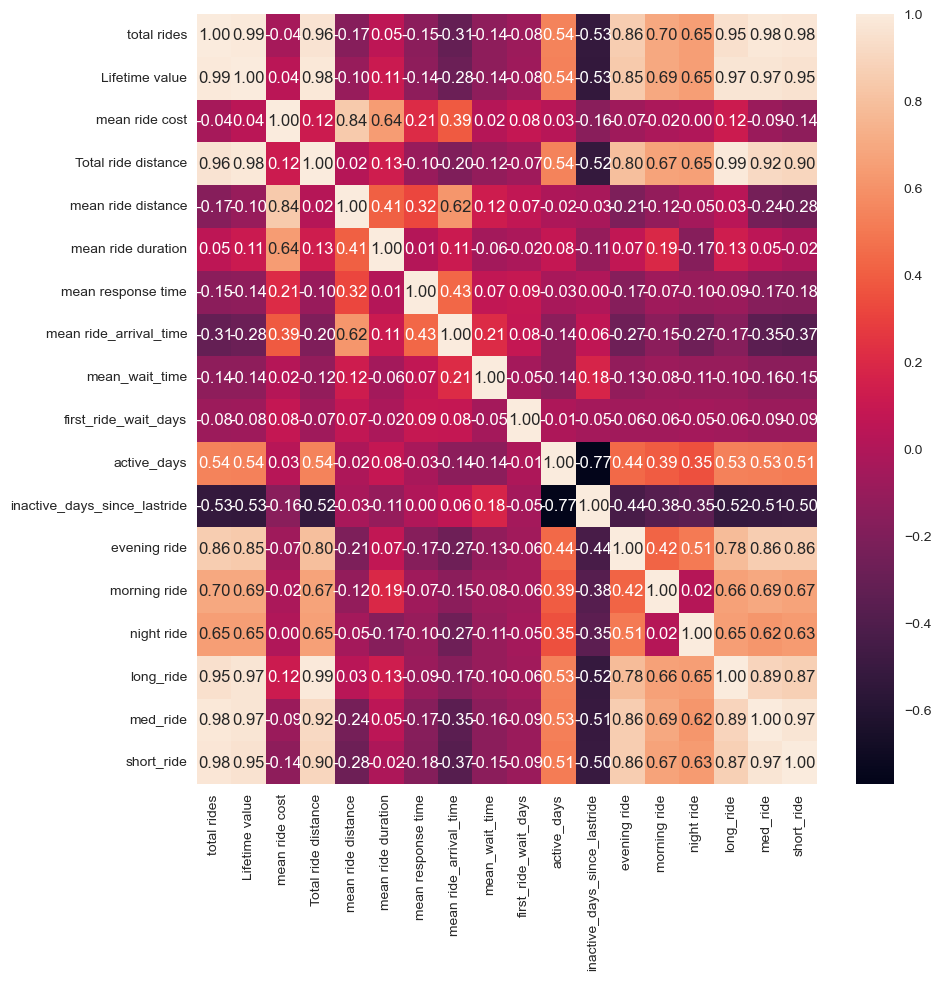

In [297]:
plt.figure(figsize=(10,10))
corr_matrix=temp.corr()
sns.heatmap(corr_matrix,annot=True, fmt=".2f")
plt.show()

#### We can drop total ride cost and total ride distance

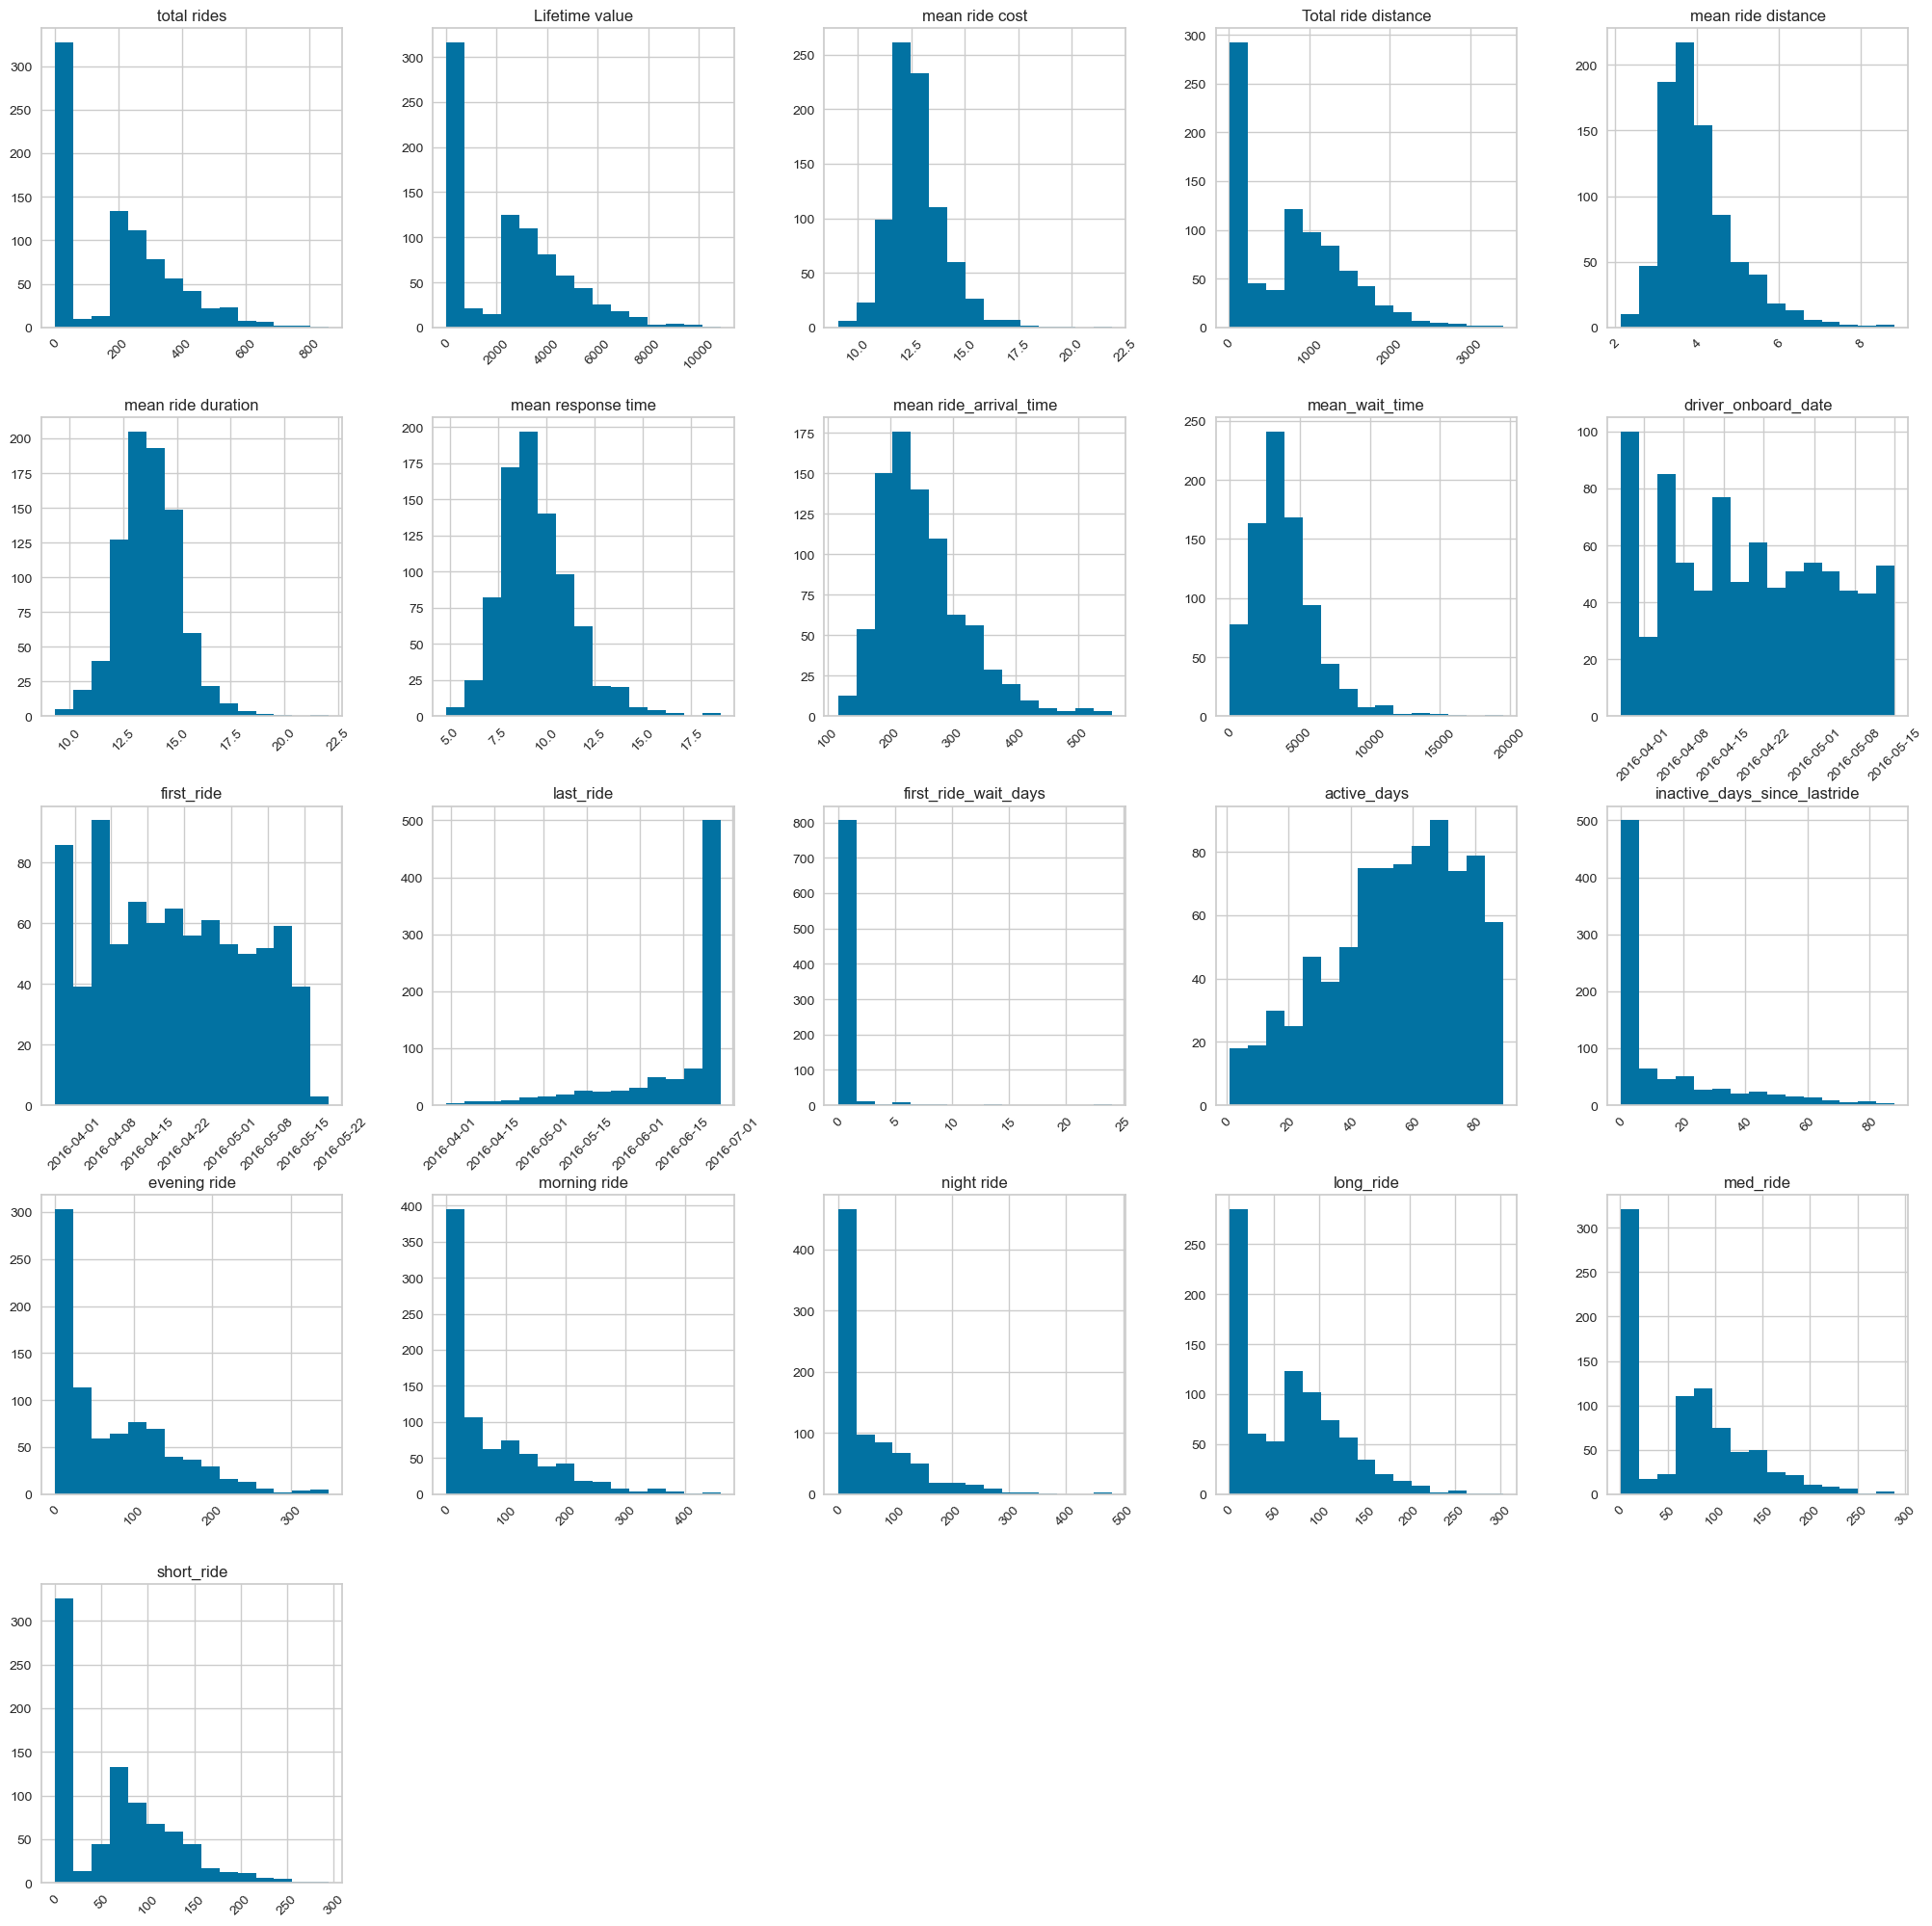

In [298]:
temp.hist(figsize=(25,25),bins = 15,xrot=45)
plt.show()

In [299]:
pd.DataFrame(temp.corr()['Lifetime value']).sort_values(by= 'Lifetime value' , ascending=False).iloc[1:]

,Lifetime value
total rides,0.992667
Total ride distance,0.982649
long_ride,0.968218
med_ride,0.967959
short_ride,0.953492
evening ride,0.845605
morning ride,0.691294
night ride,0.653687
active_days,0.535033
mean ride duration,0.109076


## Machine Learning

In [300]:
temp.columns
X=temp.drop(columns=['driver_id','driver_onboard_date', 'first_ride', 'last_ride'])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


pca=PCA(2)
pca_df=pca.fit_transform(X_scaled)


# k_values = range(2, 10)
# cluster_labels = []
# wcss=[]

# # Perform k-means clustering for each k value
# for k in k_values:
#     kmeans = KMeans(n_clusters=k,random_state=0)
#     kmeans.fit(pca_df)
#     cluster_labels.append(kmeans.labels_)
#     wcss.append(kmeans.inertia_)



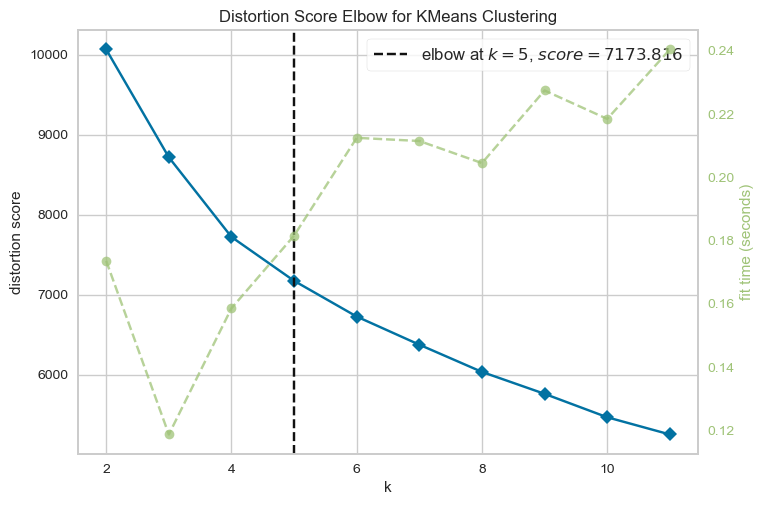

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [301]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')

# Use the KElbowVisualizer to determine the optimal number of clusters
model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=(2,12))
visualizer.fit(X_scaled)
visualizer.show()


In [302]:
kmeans = KMeans(n_clusters=visualizer.elbow_value_, random_state=42)
kmeans.fit(X_scaled)

KMeans(n_clusters=5, random_state=42)

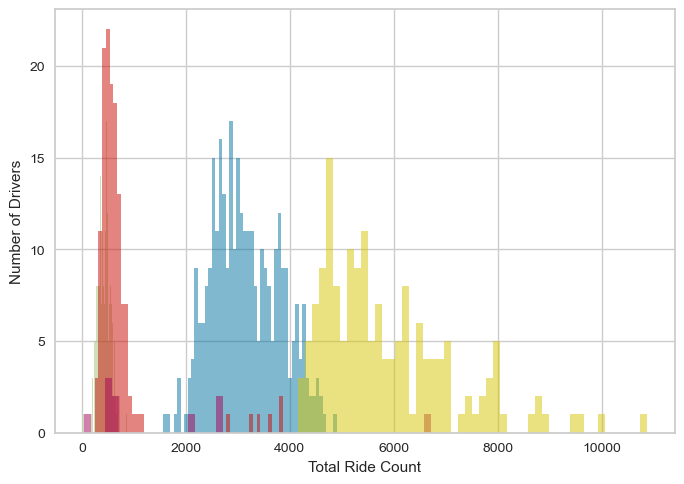

In [303]:
X['cluster'] = kmeans.labels_
X['cluster']=X['cluster'].astype('str')
# Plot the distribution of total ride count by cluster
X.groupby('cluster')['Lifetime value'].plot.hist(bins=50, alpha=0.5)
plt.xlabel('Total Ride Count')
plt.ylabel('Number of Drivers')
plt.show()


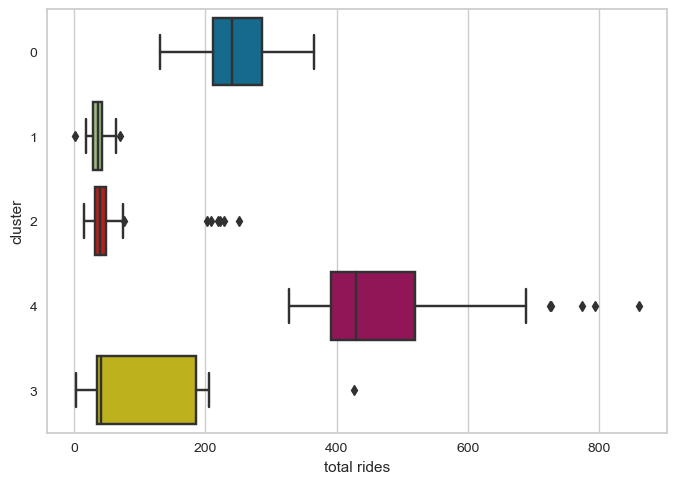

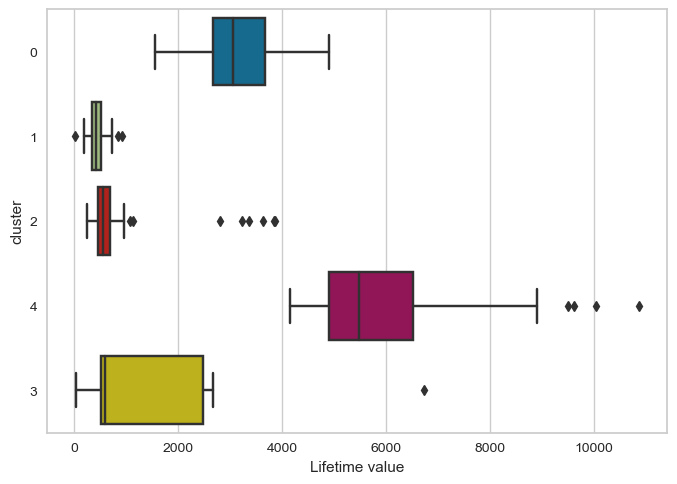

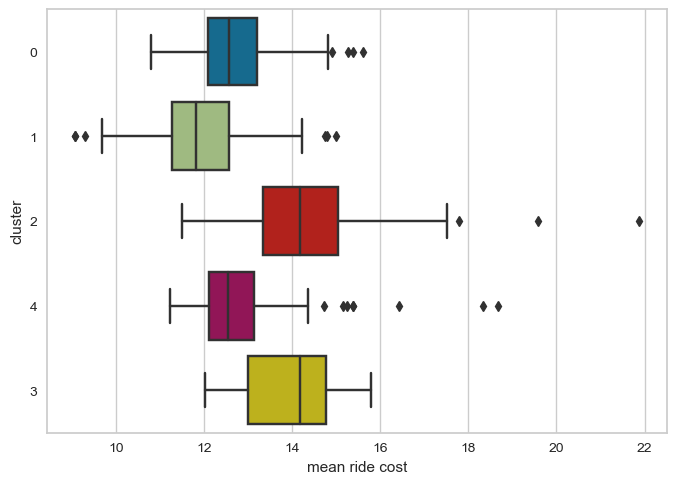

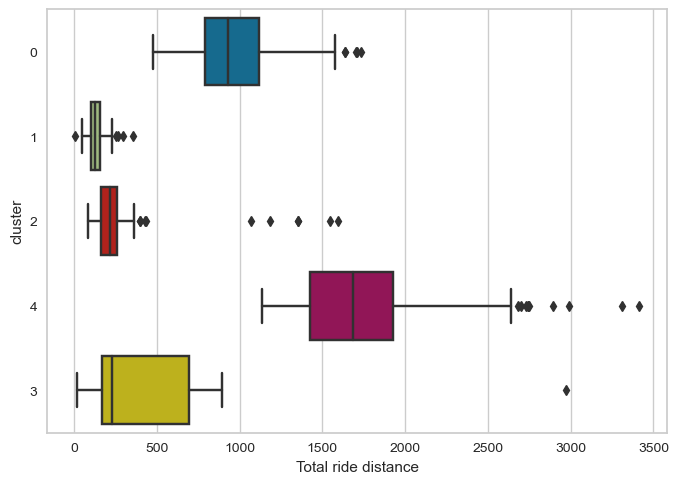

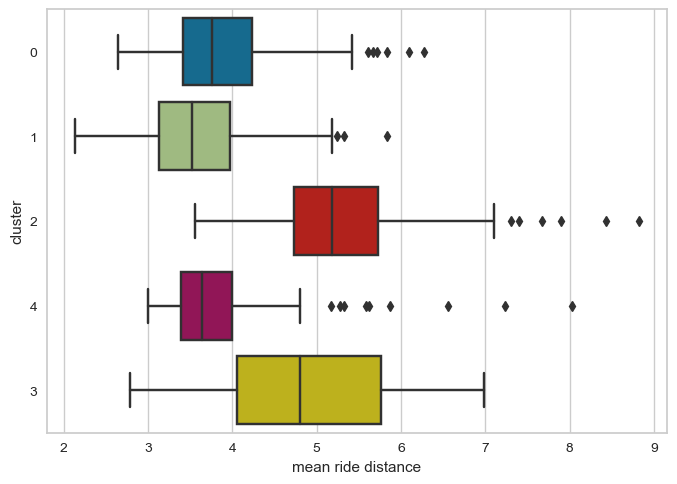

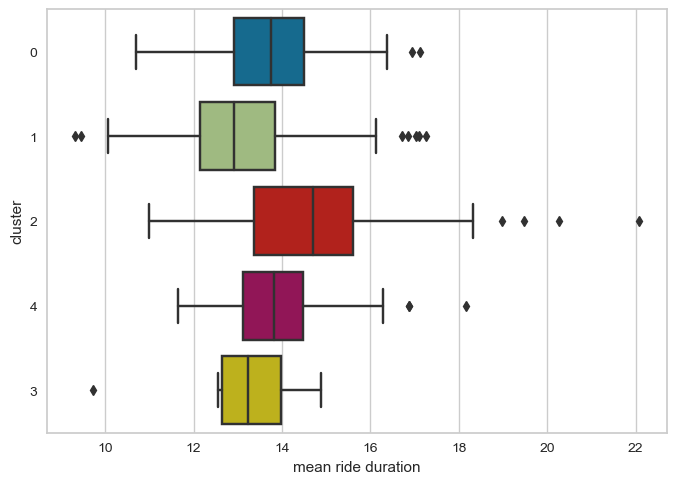

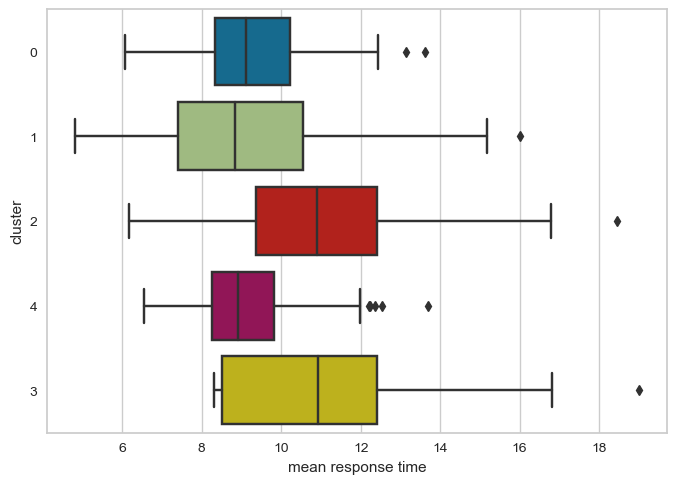

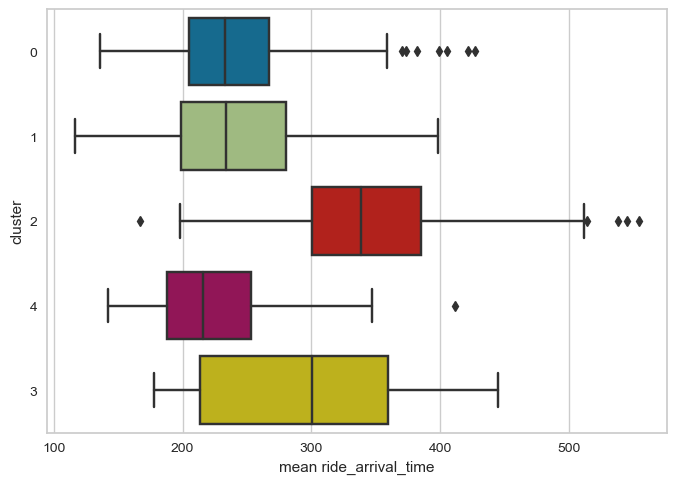

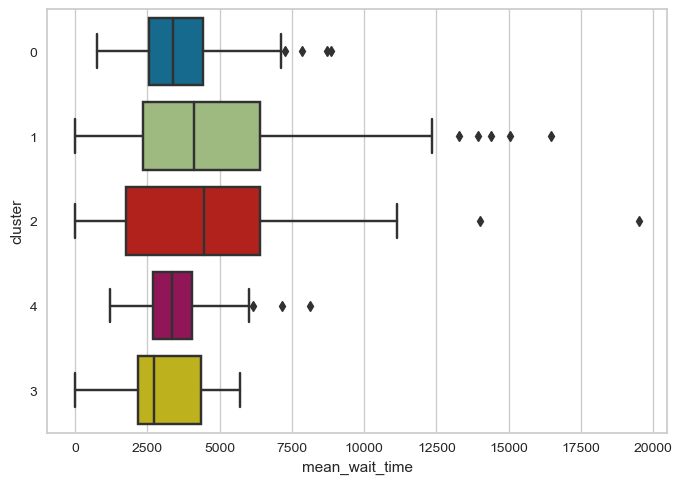

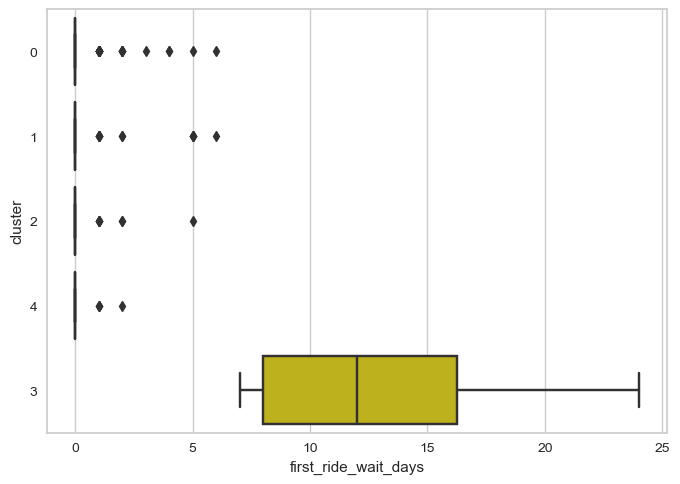

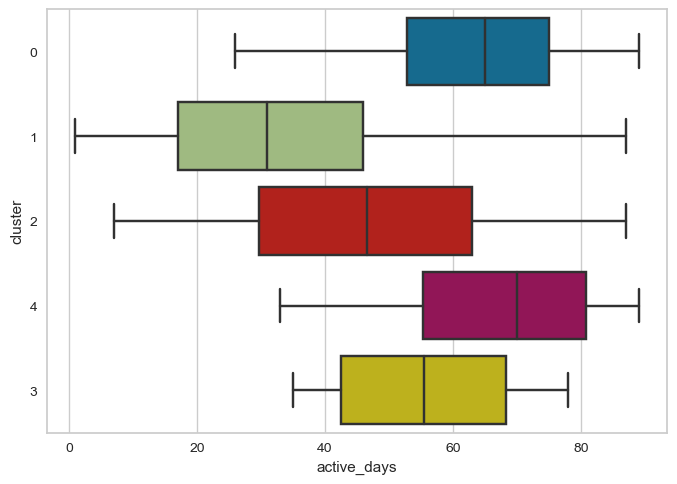

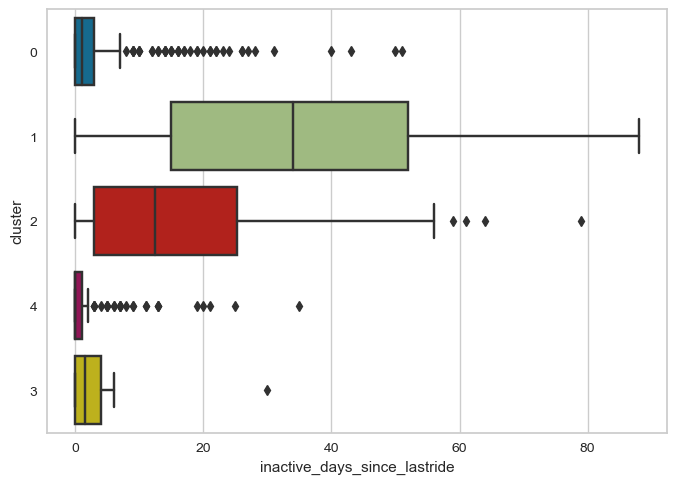

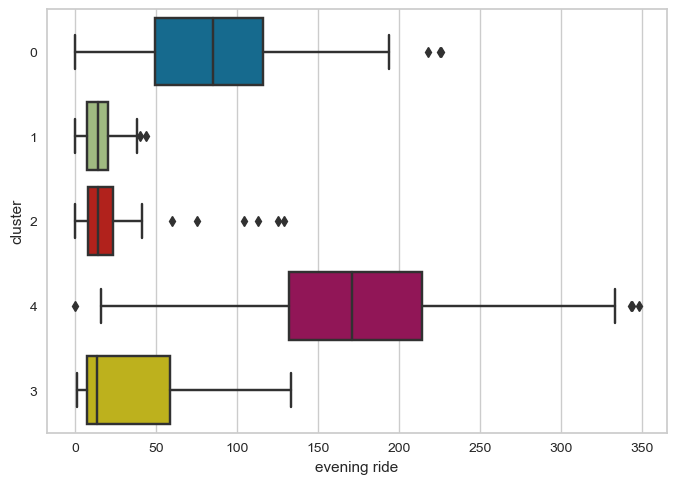

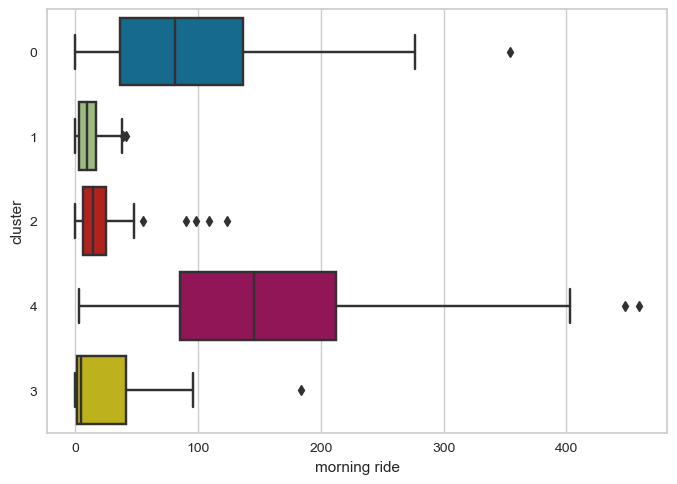

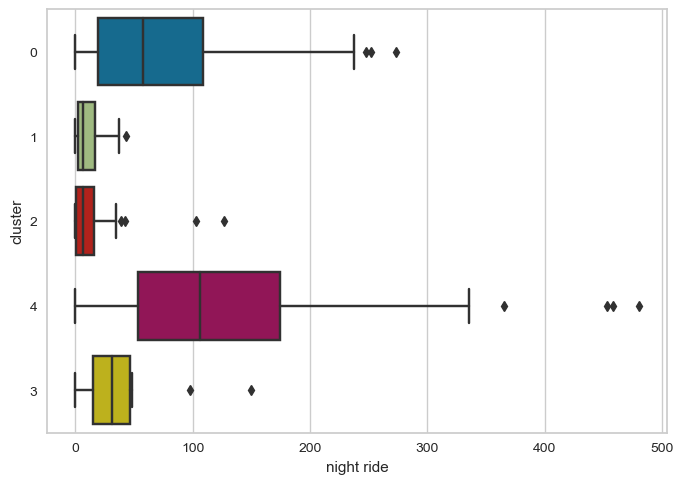

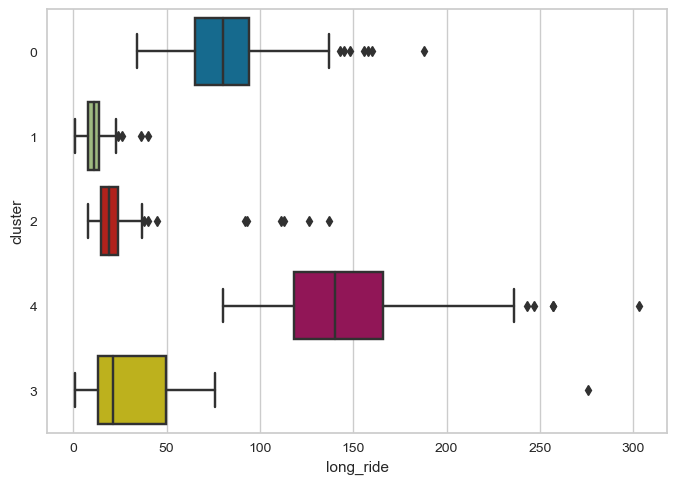

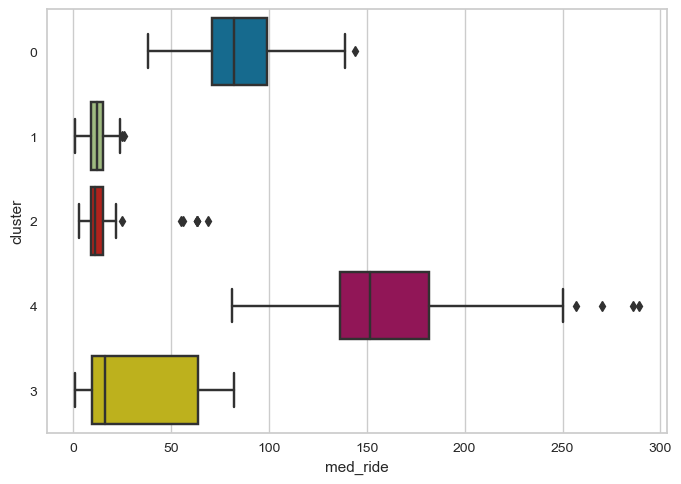

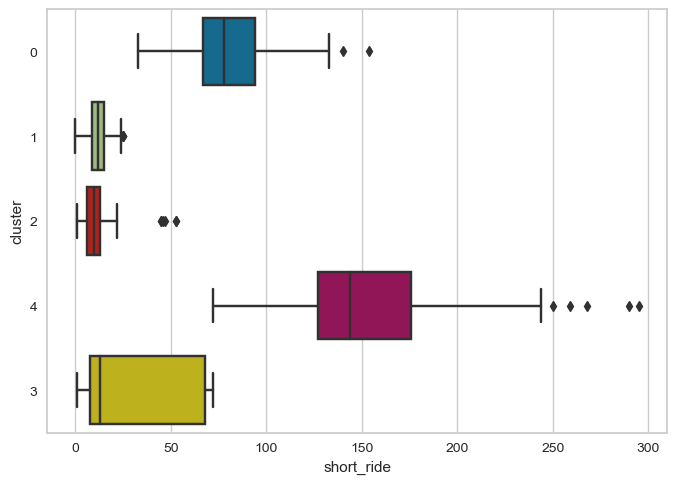

In [304]:
for i in X.columns[:-1]:
    sns.boxplot(data=X, x=i, y="cluster")
    plt.show()

In [305]:
X

,total rides,Lifetime value,mean ride cost,Total ride distance,mean ride distance,mean ride duration,mean response time,mean ride_arrival_time,mean_wait_time,first_ride_wait_days,active_days,inactive_days_since_lastride,evening ride,morning ride,night ride,long_ride,med_ride,short_ride,cluster
0,263,3224.327344,12.259800,932.761756,3.546623,13.038150,6.737643,172.079848,3619.026616,0,85,3,79,85,99,75,100,88,0
1,30,315.013285,10.500443,72.689844,2.422995,11.271667,12.033333,175.400000,5764.933333,0,84,4,18,3,9,5,15,10,1
2,33,400.227030,12.128092,114.066939,3.456574,12.416667,7.303030,220.969697,5240.575758,0,68,14,21,7,5,10,11,12,1
3,179,2478.211994,13.844760,873.146801,4.877915,15.462104,10.357542,236.033520,2906.787709,2,61,0,16,69,94,96,48,35,0
4,354,4904.243581,13.853795,1706.752037,4.821333,15.525659,7.757062,211.898305,3669.064972,0,56,2,0,354,0,148,106,100,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
832,227,3020.435371,13.305883,1001.623954,4.412440,15.581865,12.013216,273.162996,5335.524229,0,61,0,63,143,21,88,56,83,0
833,461,5935.593928,12.875475,1656.318460,3.592882,15.090672,9.134490,181.075922,4688.422993,0,81,9,170,276,15,155,146,160,4
834,33,351.201181,10.642460,96.950032,2.937880,13.159091,13.272727,226.212121,5238.545455,0,34,45,2,31,0,9,7,17,1
835,376,5250.544768,13.964215,1476.576335,3.927065,14.156738,8.582447,202.000000,3457.981383,0,50,0,112,143,121,122,138,116,4


In [218]:
rf = RandomForestClassifier()
rf.fit(X.drop(columns=['cluster']), X['cluster'])

# Get feature importances
feature_importances = rf.feature_importances_

# Print feature importance scores
for feature, importance in sorted(zip(X.columns, feature_importances), key=lambda x: x[1], reverse=True):
    print(f"{feature}: {importance}")

Lifetime value: 0.15873779741627217
total rides: 0.14598691831073954
Total ride distance: 0.12223163407744003
med_ride: 0.11475430136471426
short_ride: 0.09398663254226641
mean ride distance: 0.08019212839701381
mean ride cost: 0.05833961904779882
long_ride: 0.05563156394015834
mean ride_arrival_time: 0.0356808157000905
evening ride: 0.027038676697755
morning ride: 0.018622552375476983
mean ride duration: 0.01759710152210188
mean response time: 0.016164933566802292
inactive_days_since_lastride: 0.013745912117080272
first_ride_wait_days: 0.012911532599433713
active_days: 0.012867219309019174
night ride: 0.010274508077821279
mean_wait_time: 0.005236152938015486


In [307]:
X.to_csv('Results.csv')

#### Cluster analysis for the 5 clusters
Cluster 0:  Midtime mid revenue generating drivers \
Cluster 4:  Longtime high revenue generating drivers \
\
The remaining 3 clusters belong to new drivers. 

Cluster 1:  \
Cluster 2:  \
Cluster 3:  

# Churn Prediction Problem
#### Assumption: Drivers are considered as churned if they are not active in last 3 weeks

In [234]:
churn_df=temp
churn_df['churned']=np.where(churn_df['inactive_days_since_lastride']>21,1,0)
churn_df.head()

,driver_id,total rides,Lifetime value,mean ride cost,Total ride distance,mean ride distance,mean ride duration,mean response time,mean ride_arrival_time,mean_wait_time,...,first_ride_wait_days,active_days,inactive_days_since_lastride,evening ride,morning ride,night ride,long_ride,med_ride,short_ride,churned
0,002be0ffdc997bd5c50703158b7c2491,263,3224.327344,12.259800,932.761756,3.546623,13.038150,6.737643,172.079848,3619.026616,...,0,85,3,79,85,99,75,100,88,0
1,007f0389f9c7b03ef97098422f902e62,30,315.013285,10.500443,72.689844,2.422995,11.271667,12.033333,175.400000,5764.933333,...,0,84,4,18,3,9,5,15,10,0
2,011e5c5dfc5c2c92501b8b24d47509bc,33,400.227030,12.128092,114.066939,3.456574,12.416667,7.303030,220.969697,5240.575758,...,0,68,14,21,7,5,10,11,12,0
3,0152a2f305e71d26cc964f8d4411add9,179,2478.211994,13.844760,873.146801,4.877915,15.462104,10.357542,236.033520,2906.787709,...,2,61,0,16,69,94,96,48,35,0
4,01674381af7edd264113d4e6ed55ecda,354,4904.243581,13.853795,1706.752037,4.821333,15.525659,7.757062,211.898305,3669.064972,...,0,56,2,0,354,0,148,106,100,0


In [235]:
churn_df.churned.value_counts()

0    642
1    195
Name: churned, dtype: int64

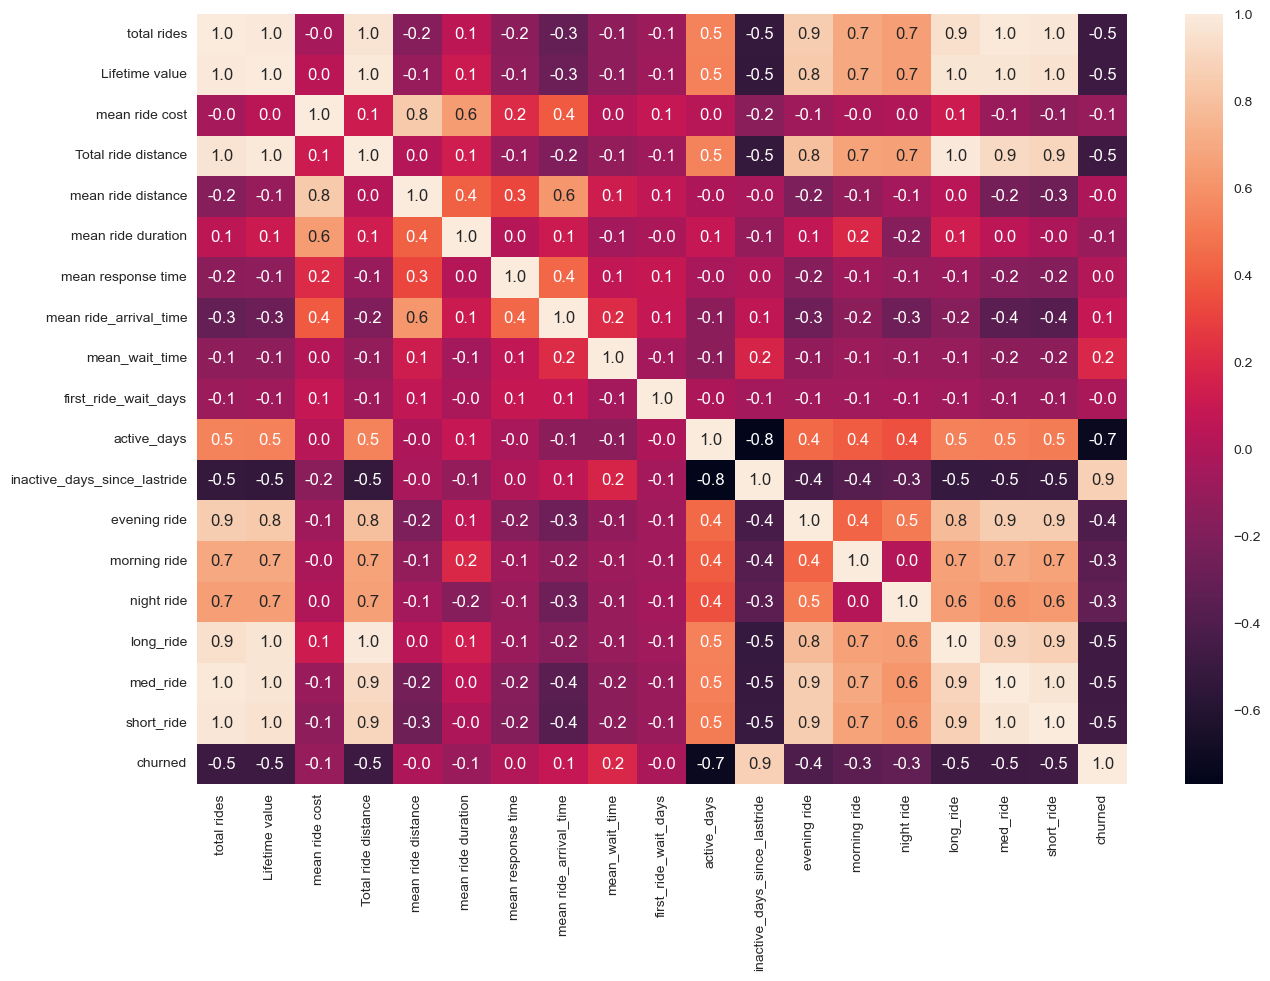

In [240]:
plt.figure(figsize=(15,10))
corr_matrix=churn_df.corr()
sns.heatmap(corr_matrix,annot=True, fmt=".1f")
plt.show()

In [242]:
## drop correlated variables
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
print ("Dropped columns from Correlation: ", to_drop)

churn_df.drop(to_drop,axis=1,inplace=True)

Dropped columns from Correlation:  ['Lifetime value', 'Total ride distance', 'long_ride', 'med_ride', 'short_ride']


## Logistic Regression

In [264]:
## Select features for Logistic Regression

data=churn_df

Y=data['churned']
X=data.drop(['churned','driver_id','driver_onboard_date', 'first_ride', 'last_ride','inactive_days_since_lastride'],axis=1)
X=X.select_dtypes(exclude='object')

print ("Selected Features: ",X.columns.tolist())

Selected Features:  ['total rides', 'mean ride cost', 'mean ride distance', 'mean ride duration', 'mean response time', 'mean ride_arrival_time', 'mean_wait_time', 'first_ride_wait_days', 'active_days', 'evening ride', 'morning ride', 'night ride']


Classification Report: 

               precision    recall  f1-score   support

           0       0.91      0.97      0.94       198
           1       0.85      0.65      0.74        54

    accuracy                           0.90       252
   macro avg       0.88      0.81      0.84       252
weighted avg       0.90      0.90      0.90       252

F1 score:  0.8378587054433149


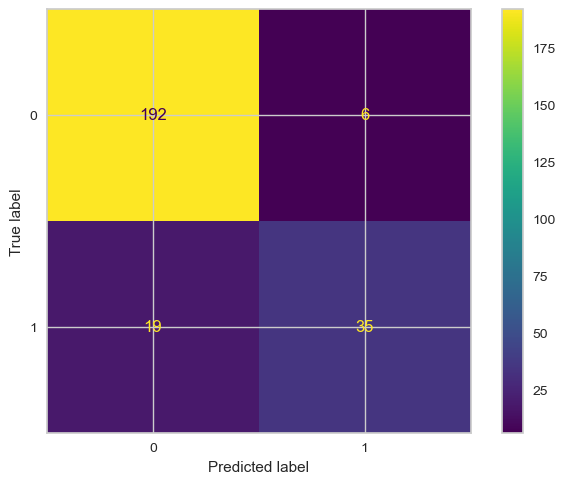

In [265]:
## Standardization

#scaler=MinMaxScaler()
scaler=StandardScaler()
scaled_data=scaler.fit_transform(X)

## Train test split
train_X,test_X,train_Y,test_Y = train_test_split(scaled_data,Y, test_size=0.3)

## Modeling

logistic_model=LogisticRegression()
logistic_model.fit(train_X,train_Y)

## Prediction
preds=logistic_model.predict(test_X)


## Evaluation

print ("Classification Report: \n\n", classification_report(test_Y,preds))
print ("F1 score: ",f1_score(test_Y,preds,average='macro'))
cm = confusion_matrix(test_Y, preds, labels=logistic_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logistic_model.classes_)
disp.plot()

<AxesSubplot:ylabel='Feature'>

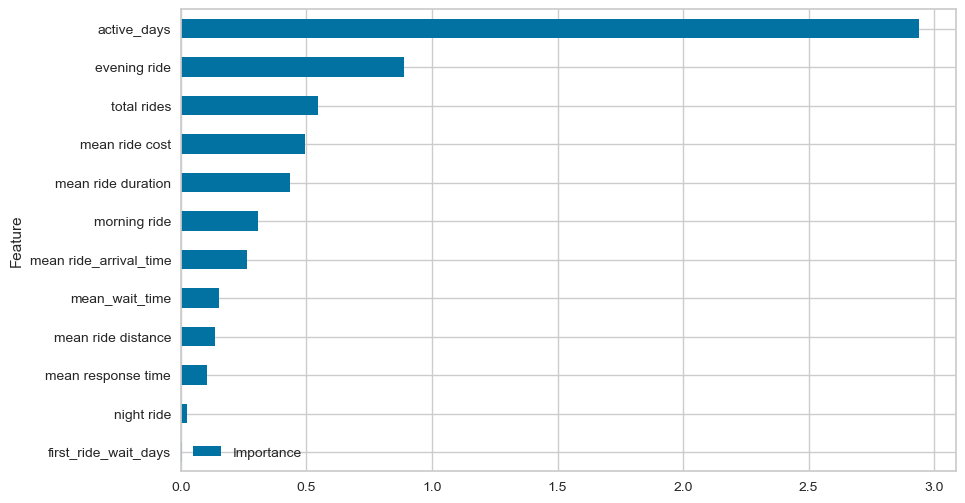

In [266]:
## Feature importance
coefficients = logistic_model.coef_[0]

feature_importance = pd.DataFrame({'Feature':X.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

## Other Models

In [267]:
data=churn_df
Y=data['churned']
X=data.drop(['churned','driver_id','driver_onboard_date', 'first_ride', 'last_ride','inactive_days_since_lastride'],axis=1)
X=X.select_dtypes(exclude='object')
print ("Selected Features: ",X.columns.tolist())
scaler=StandardScaler()
scaled_data=scaler.fit_transform(X)

## Train test split
train_X,test_X,train_Y,test_Y = train_test_split(scaled_data,Y, test_size=0.3)


classifiers={
    "Rnadom Forest": RandomForestClassifier(),
    "Linear SVM": SVC(kernel="linear", C=0.025),
    "RBF SVM": SVC(gamma=2, C=1),
    "Decision Tree": DecisionTreeClassifier(max_depth=5, random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "XGBoost" : XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', seed=0),
    "LightGBM": LGBMClassifier(random_state=42)}

for name, model in classifiers.items():
    model.fit(train_X,train_Y)
    preds=model.predict(test_X)
    print ("Model:",name,"\nF1 score: ",f1_score(test_Y,preds,average='macro'))
    print ("Classification Report: \n\n", classification_report(test_Y,preds))


Selected Features:  ['total rides', 'mean ride cost', 'mean ride distance', 'mean ride duration', 'mean response time', 'mean ride_arrival_time', 'mean_wait_time', 'first_ride_wait_days', 'active_days', 'evening ride', 'morning ride', 'night ride']
Model: Rnadom Forest 
F1 score:  0.8366379792109087
Classification Report: 

               precision    recall  f1-score   support

           0       0.94      0.91      0.93       197
           1       0.72      0.78      0.75        55

    accuracy                           0.88       252
   macro avg       0.83      0.85      0.84       252
weighted avg       0.89      0.88      0.89       252

Model: Linear SVM 
F1 score:  0.8526315789473684
Classification Report: 

               precision    recall  f1-score   support

           0       0.94      0.92      0.93       197
           1       0.75      0.80      0.77        55

    accuracy                           0.90       252
   macro avg       0.84      0.86      0.85       252